# State of the art AutoML systems: auto-sklearn and TPOT


### 1. Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
try:
    import autosklearn
except:
    !pip install auto-sklearn
from autosklearn.pipeline.components.base import AutoSklearnPreprocessingAlgorithm
from autosklearn.pipeline.constants import SPARSE, DENSE, UNSIGNED_DATA, INPUT
from ConfigSpace.configuration_space import ConfigurationSpace
from sklearn.impute import SimpleImputer
import autosklearn.regression
try:
    import tpot
except:
    !pip install tpot
from tpot import TPOTRegressor
!pip install --upgrade ipywidgets
!pip install --upgrade jupyter_client

import random
from math import e
from time import time
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.preprocessing import normalize

  Using cached auto-sklearn-0.14.2.tar.gz (6.3 MB)
     |████████████████████████████████| 22.3 MB 14.7 MB/s 
     |████████████████████████████████| 973 kB 27.9 MB/s 
     |████████████████████████████████| 722 kB 41.8 MB/s 
     |████████████████████████████████| 4.2 MB 38.1 MB/s 
     |████████████████████████████████| 4.0 MB 37.3 MB/s 
     |████████████████████████████████| 208 kB 49.1 MB/s 
     |████████████████████████████████| 132 kB 48.9 MB/s 
     |████████████████████████████████| 299 kB 54.4 MB/s 
     |████████████████████████████████| 296 kB 19.1 MB/s 
     |████████████████████████████████| 1.9 MB 39.7 MB/s 
     |████████████████████████████████| 45 kB 4.4 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.2-py3-none-any.whl size=6586720 sha256=2768218b360797f1d4071fcdd215f2f01400105b6150eb5658a2d77c9e9669a2
  Stored in directory: /root/.cache/pip/wheels/b6/ba/aa/ce7b8deb41019b9c1c6cd0b511d553350b7075ba1d3f0f545c
  Created wheel for liac-arff: filename=

## 2. Data loading and preprocessing 

In [ ]:
def transform_data(data, target_var, scale=True):
    if scale:
        std_scaler = StandardScaler()
        X = pd.DataFrame(
        std_scaler.fit_transform(data.drop(target_var, axis=1)), columns=data.drop(target_var, axis=1).columns
        )
        y = data[target_var].reset_index().drop("index", axis=1)
    else:
        X = data.drop(target_var, axis=1)
        y = data[target_var].reset_index().drop("index", axis=1)
    return X, y

#### 2.1. Insurance dataset
Dataset needed to be one hot encoded and scaled.

In [ ]:
def load_insurance_data():
    insurance_df = pd.read_csv("datasets/insurance.csv")
    categorical_cols = ["sex", "smoker", "region"]

    for col in categorical_cols:
        insurance_df[col] = insurance_df[col].astype('category')

    insurance_df = pd.get_dummies(insurance_df, columns = categorical_cols)
    # for features with only two possible values we don't need both hot encoding columns so i drop them
    insurance_df = insurance_df.drop(["sex_male", "smoker_yes"], axis=1)

    # train test split
    data_training, data_testing = train_test_split(insurance_df, test_size=0.2, random_state=234)

    insurance_X_train, insurance_y_train = transform_data(data_training, "charges")
    insurance_X_test, insurance_y_test = transform_data(data_testing, "charges")

    return insurance_X_train, insurance_y_train, insurance_X_test, insurance_y_test

insurance_X_train, insurance_y_train, insurance_X_test, insurance_y_test = load_insurance_data()

# display(insurance_X_train.head())
# display(insurance_y_train.head())

#### 2.2. 

In [ ]:

def load_paris_housing_data():
    paris_housing_df = pd.read_csv("datasets/ParisHousing.csv")
    #Class is only needed for cal
    categorical_cols = ["cityCode", "made"]

    for col in categorical_cols:
        paris_housing_df[col] = paris_housing_df[col].astype('category')

    paris_housing_df = pd.get_dummies(paris_housing_df, columns = categorical_cols)

    # train test split
    data_training, data_testing = train_test_split(paris_housing_df, test_size=0.2, random_state=234)

    paris_housing_X_train, paris_housing_y_train = transform_data(data_training, "price")
    paris_housing_X_test, paris_housing_y_test = transform_data(data_testing, "price")

    return paris_housing_X_train, paris_housing_y_train, paris_housing_X_test, paris_housing_y_test

paris_housing_X_train, paris_housing_y_train, paris_housing_X_test, paris_housing_y_test = load_paris_housing_data()

#### 2.3.

In [ ]:
def load_financial_data():
    financial_df = pd.read_csv("datasets/2018_Financial_Data.csv")
    #Class is only needed for classification, regression is done via 2019 PRICE VAR [%]

    financial_df.drop('Class', axis=1, inplace=True)
    #Drop the first row as it only contains names
    financial_df.drop(financial_df.columns[[0]], axis=1, inplace=True)
    #Change target to a better name
    financial_df = financial_df.rename(columns={"2019 PRICE VAR [%]":"prive_var"})

    categorical_cols = ["Sector"]

    for col in categorical_cols:
        financial_df[col] = financial_df[col].astype('category')

    financial_df = pd.get_dummies(financial_df, columns = categorical_cols)
    # train test split
    data_training, data_testing = train_test_split(financial_df, test_size=0.2, random_state=234)


    #impute missing values
    imputerMean = SimpleImputer(strategy='mean', missing_values=np.nan)
    financial_df = pd.DataFrame(imputerMean.fit_transform(financial_df.values), columns=financial_df.columns.values.tolist())

    financial_X_train, financial_y_train = transform_data(financial_df, "prive_var")
    financial_X_test, financial_y_test = transform_data(financial_df, "prive_var")

    return financial_X_train, financial_y_train, financial_X_test, financial_y_test

financial_X_train, financial_y_train, financial_X_test, financial_y_test = load_financial_data()
display(financial_X_train)
display(financial_y_train)

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,Sector_Technology,Sector_Utilities
0,4.384956,-0.017383,-0.212997,12.125810,-0.130053,17.801282,13.684570,6.206957,9.303462,5.559496,...,-0.143817,2.771253,-0.213226,-0.244634,-0.480564,-0.432095,-0.387738,-0.248272,-0.411496,-0.154195
1,0.442712,-0.017796,0.280596,0.631062,-0.130053,-0.083407,0.300521,1.061794,4.911039,0.625594,...,-0.143817,-0.360848,-0.213226,4.087747,-0.480564,-0.432095,-0.387738,-0.248272,-0.411496,-0.154195
2,3.224353,-0.017292,1.623147,5.467719,14.794099,1.629007,3.507955,7.663428,-0.611249,8.694425,...,-0.143817,-0.360848,-0.213226,-0.244634,-0.480564,-0.432095,-0.387738,-0.248272,2.430156,-0.154195
3,1.239716,-0.015386,0.633589,2.078217,2.229292,-0.024368,0.270034,4.849229,0.653768,5.250817,...,-0.143817,-0.360848,-0.213226,-0.244634,-0.480564,-0.432095,-0.387738,-0.248272,2.430156,-0.154195
4,5.714752,-0.017814,6.252280,3.161845,-0.130053,4.792893,7.256952,-5.143851,13.403957,-8.530873,...,-0.143817,-0.360848,-0.213226,-0.244634,-0.480564,-0.432095,2.579063,-0.248272,-0.411496,-0.154195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,-0.251129,-0.017962,-0.212997,-0.268049,-0.130053,-0.249732,-0.264553,-0.222470,-0.240776,-0.219005,...,-0.143817,-0.360848,-0.213226,-0.244634,-0.480564,-0.432095,-0.387738,4.027844,-0.411496,-0.154195
4388,-0.251102,-0.020099,-0.212997,-0.267976,-0.124809,-0.249366,-0.263431,-0.224336,-0.270668,-0.216845,...,-0.143817,-0.360848,-0.213226,-0.244634,-0.480564,-0.432095,-0.387738,-0.248272,-0.411496,-0.154195
4389,-0.248437,-0.016813,-0.210519,-0.265650,-0.128232,-0.248823,-0.263644,-0.217948,-0.267318,-0.210126,...,-0.143817,-0.360848,-0.213226,-0.244634,-0.480564,-0.432095,-0.387738,-0.248272,-0.411496,-0.154195
4390,-0.251129,-0.017962,-0.212997,-0.268049,-0.118684,-0.249519,-0.262171,-0.226830,-0.270668,-0.219701,...,-0.143817,-0.360848,-0.213226,-0.244634,-0.480564,-0.432095,2.579063,-0.248272,-0.411496,-0.154195


,prive_var
0,32.794573
1,40.588068
2,30.295514
3,64.213737
4,44.757840
...,...
4387,-90.962099
4388,-77.922077
4389,-17.834400
4390,-73.520000


## 3. Auto-ml logic

#### 3.1. Prepare a custom NoPreprocessing component for sklearn
To compare each AutoMl algorithm, we decided to disable looking for preprocessing steps for the state of the art algorithms. We do it because our algorithm also doesn't look for them. To disable preprocessing in auto-sklearn we had to create a custom component.

In [ ]:
# https://automl.github.io/auto-sklearn/master/examples/80_extending/example_extending_data_preprocessor.html#create-nopreprocessing-component-for-auto-sklearn

class NoPreprocessing(AutoSklearnPreprocessingAlgorithm):

    def __init__(self, **kwargs):
        """ This preprocessors does not change the data """
        # Some internal checks makes sure parameters are set
        for key, val in kwargs.items():
            setattr(self, key, val)

    def fit(self, X, Y=None):
        return self

    def transform(self, X):
        return X

    @staticmethod
    def get_properties(dataset_properties=None):
        return {
            'shortname': 'NoPreprocessing',
            'name': 'NoPreprocessing',
            'handles_regression': True,
            'handles_classification': True,
            'handles_multiclass': True,
            'handles_multilabel': True,
            'handles_multioutput': True,
            'is_deterministic': True,
            'input': (SPARSE, DENSE, UNSIGNED_DATA),
            'output': (INPUT,)
        }

    @staticmethod
    def get_hyperparameter_search_space(dataset_properties=None):
        return ConfigurationSpace()  # Return an empty configuration as there is None

autosklearn.pipeline.components.data_preprocessing.add_preprocessor(NoPreprocessing)

#### 3.2. Prepare methods that can be used by all algoritms

In [ ]:
def get_single_best_optimization_score(array):
    new_array = np.array([array[0]])
    for i in range(1, len(array)):
        min_of_previous_values = min(new_array[0: i])
        if array[i] > min_of_previous_values:
            new_array = np.append(new_array, min_of_previous_values)
        else:
            new_array = np.append(new_array, array[i])
    return new_array

def create_graphs(mse_over_time_vector, summary_folder_path):
    plt.rcParams['figure.figsize'] = [20, 5]

    plt.plot(
        range(1, mse_over_time_vector.size+1),
        get_single_best_optimization_score(mse_over_time_vector),
        label="Best MSE of previously evaluated models"
    )
    plt.ylim(bottom=None, top=np.median(mse_over_time_vector)*5)
    plt.plot(
        range(1, mse_over_time_vector.size+1),
        mse_over_time_vector,
        label="MSE of currently evaluated model"
    )
    plt.ylim(bottom=None, top=np.median(mse_over_time_vector)*5)
    plt.title("Improvement of MSE over number of models evaluated")
    plt.xlabel("Number of models evaluated")
    plt.ylabel("MSE")
    plt.legend(loc="upper right")
    plt.grid()
    plt.savefig(summary_folder_path + 'mse_plot.png')
    plt.show()

    plt.plot(
        range(1, mse_over_time_vector.size+1),
        get_single_best_optimization_score(mse_over_time_vector),
        label="Best MSE of previously evaluated models"
    )
    plt.ylim(bottom=None, top=np.median(mse_over_time_vector)*2)
    plt.title("Best MSE of previously evaluated models")
    plt.xlabel("Number of models evaluated")
    plt.ylabel("MSE")
    plt.legend(loc="upper right")
    plt.grid()
    plt.savefig(summary_folder_path + 'mse_plot_2.png')
    plt.show()

    plt.rcParams.update(plt.rcParamsDefault)

def save_summary_to_file(info, summary_folder_path):
    with open(summary_folder_path + "summary.txt", "w") as f:
        f.write(info)

def create_summary(X_train, y_train, X_test, y_test, automl, results_df, optimal_params, min_mse, summary_folder_path):
    # test data
    y_predicted = automl.predict(X_test)
    mae = mean_squared_error(y_test, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    info = "MSE on test data: " + str(mae) + "\n"
    info += "R^2 on test data: " + str(r2) + "\n"

    # train data
    y_predicted = automl.predict(X_train)
    mae = mean_squared_error(y_train, y_predicted)
    r2 = r2_score(y_train, y_predicted)
    info += "MSE on train data: " + str(mae) + "\n"
    info += "R^2 on train data: " + str(r2) + "\n"
    info += "Min MSE from algorithm evaluation: " + str(min_mse) + "\n"

    info += "Best hyperparameters: " + str(optimal_params) + "\n"
    save_summary_to_file(info, summary_folder_path)

    display(results_df)
    pd.DataFrame(results_df).to_csv(summary_folder_path + "result.csv", mode='w+')

#### 3.3. Auto-sklearn logic

In [ ]:
def fit_autosklearn(X_train, y_train, X_test, y_test):
    automl = autosklearn.regression.AutoSklearnRegressor(
        include = {
            'regressor': ["random_forest", "liblinear_svr", "sgd"],
            'data_preprocessor': ['NoPreprocessing'],
            'feature_preprocessor': ["no_preprocessing"],
        },
        exclude=None,
        time_left_for_this_task=3600,
        initial_configurations_via_metalearning=0,
        metric=autosklearn.metrics.mean_squared_error,
        per_run_time_limit=240,
        # n_jobs=-1,
        # memory_limit=None,
    )

    automl.fit(X_train, y_train)
    return automl

def create_results_autosklearn(X_train, y_train, X_test, y_test, automl, summary_folder_path):
    results = pd.DataFrame(automl.cv_results_)
    create_summary(X_train, y_train, X_test, y_test,
        automl, results, results.sort_values("mean_test_score").loc[0, "params"], min(np.array(results["mean_test_score"])), summary_folder_path,
    )

    mse_over_time_vector = np.array(results["mean_test_score"])
    create_graphs(mse_over_time_vector, summary_folder_path)

def do_autosklearn(X_train, y_train, X_test, y_test, summary_folder_path):
    automl = fit_autosklearn(X_train, y_train, X_test, y_test)
    create_results_autosklearn(X_train, y_train, X_test, y_test, automl, summary_folder_path)

    return automl

#### 3.4. Tpot logic

In [ ]:
def fit_tpot(X_train, y_train, X_test, y_test):
    # https://github.com/EpistasisLab/tpot/blob/master/tpot/config/regressor.py
    tpot_config = {
        'sklearn.ensemble.RandomForestRegressor': {
            'n_estimators': [100],
            'max_features': np.arange(0.05, 1.01, 0.05),
            'min_samples_split': range(2, 21),
            'min_samples_leaf': range(1, 21),
            'bootstrap': [True, False]
        },
        # 'sklearn.svm.SVR': {
        #     'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        #     'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        #     'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.],
        #     # "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
        #     # "degree": [2, 3, 4, 5],
        # },
        'sklearn.svm.LinearSVR': {
            'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
            'dual': [True, False],
            'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
            'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
            'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
        },
        'sklearn.linear_model.SGDRegressor': {
            'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
            'penalty': ['elasticnet'],
            'alpha': [0.0, 0.01, 0.001] ,
            'learning_rate': ['invscaling', 'constant'] ,
            'fit_intercept': [True, False],
            'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
            'eta0': [0.1, 1.0, 0.01],
            'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
        },
    }

    tpot = TPOTRegressor(
        generations=100, population_size=100, verbosity=3, random_state=123, max_time_mins=60, config_dict=tpot_config, scoring="neg_mean_squared_error"
    )
    tpot.fit(X_train, y_train)
    return tpot

def create_results_tpot(X_train, y_train, X_test, y_test, automl, summary_folder_path):
    results = pd.DataFrame(automl.evaluated_individuals_)
    mse_over_time_vector = results.loc["internal_cv_score"].to_numpy(copy=True)*(-1)
    # to make the plot readable we had to delete very high values of MAE
    # mse_over_time_vector = mse_over_time_vector[mse_over_time_vector < np.median(mse_over_time_vector)*10]

    create_graphs(mse_over_time_vector, summary_folder_path)

    create_summary(X_train, y_train, X_test, y_test,
        automl, results, list(automl.evaluated_individuals_.keys())[0],  min(mse_over_time_vector), summary_folder_path,
    )

def do_tpot(X_train, y_train, X_test, y_test, summary_folder_path):
    automl = fit_tpot(X_train, y_train, X_test, y_test)
    create_results_tpot(X_train, y_train, X_test, y_test, automl, summary_folder_path)

    return automl

#### 3.5 Our algorithm

In [ ]:
class Classifier():
	def __init__(self, classifier, paramRanges):
		self.classifier = classifier
		self.paramRanges = paramRanges

randomForestRegressor = Classifier(RandomForestRegressor, {	'n_estimators': range(10, 200),
															'max_features': ['auto', 'sqrt', 'log2'],
															'max_depth': range(10, 110),
															'min_samples_split': range(2, 21),
															'min_samples_leaf': range(1, 21),
															'bootstrap': [True, False]})
linearSVR = Classifier(LinearSVR, {	'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
									'dual': [True],
									'tol': np.logspace(1e-5, 1e-1, 5),
									'C': np.logspace(1e-5, 1e-1, 5)+np.linspace(1, 25, 5),
									'epsilon': np.logspace(1e-5, 1e-1, 5)})
sdgRegressor = Classifier(SGDRegressor, {	'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
											'penalty': ['elasticnet'],
											'alpha': np.logspace(1e-2, 0, 3) ,
											'learning_rate': ['invscaling', 'constant'] ,
											'fit_intercept': [True, False],
											'l1_ratio': np.linspace(0.0, 1.0, 5),
											'eta0': np.logspace(1e-2, 1, 3),
											'power_t': np.logspace(0, 100, 100)})

LISTOFCLFS = [randomForestRegressor, linearSVR, sdgRegressor]

class Learning():
	def __init__(self, listOfClfs, X, y, cv):
		self.listOfClfs = listOfClfs
		self.X = X
		self.y = y
		self.cv = cv
		self.MSEs = {}
		self.params = {}
		self.times = {}

	def getRandom(self):
		params = {}
		for clf in self.listOfClfs:
			params[clf] = clf.paramRanges
		self.calculateScores(params)
		return self

	def getNeighbor(self, neigborhoodSize):
		neighborhood = self.getNeigborhood(neigborhoodSize)

		l = Learning(self.listOfClfs,self.X, self.y, self.cv)
		l.calculateScores(neighborhood)
		return l

	def calculateScores(self, paramRanges):
		for clf in self.listOfClfs:
			params = {param: random.choice(paramRange) for param, paramRange in paramRanges[clf].items()}
			scores = cross_validate(clf.classifier(**params), self.X, self.y.values.ravel(), cv=self.cv, scoring='neg_mean_squared_error')
			self.MSEs[clf] = -sum(scores['test_score'])/self.cv
			self.params[clf] = params
			self.times[clf] = sum(scores['fit_time'])/self.cv
			#self.times[clf] = sum(scores['score_time'])/cv

	def getNeigborhood(self, neigborhoodSize):
		neighborhood = {}
		for clf, params in self.params.items():
			neighborhood[clf] = {}
			for param, value in params.items():
				paramRange = clf.paramRanges[param]
				i = list(paramRange).index(value)

				start = i-neigborhoodSize if i-neigborhoodSize >= 0 else 0
				end = i+neigborhoodSize if i+neigborhoodSize < len(paramRange) else len(paramRange)-1
				neighborhood[clf][param] = paramRange[start:end+1]
		return neighborhood

	def getBestClf(self):
		return min(self.MSEs, key=self.MSEs.get)

	def getBest(self):
		clf = self.getBestClf()
		return clf.classifier.__name__, self.MSEs[clf], self.params[clf], self.times[clf]

	def __lt__(self, other):
		return min(self.MSEs.values()) < min(other.MSEs.values())

	def __eq__(self, other):
		return min(self.MSEs.values()) == min(other.MSEs.values())

	def __sub__(self, other):
		return min(self.MSEs.values()) - min(other.MSEs.values())


def simulatedAnnealing(listOfClfs, X, y, neigborhoodSize=2, cv=5, T_init=10**7, P:float=0.97, g=lambda T,t: T*0.95, num_lastChanges=10, stopAfter=600, verbose=False):
	"""
		Parameters:
		X: training features of the data
		y: target feature of the data
		neigborhoodSize: number of paramters before and after in list of parameter
			if its set to 1 the neighborhood of 3 in [1,2,3,4,5,6] would be [2,3,4]
			if its set to 2 the neighborhood of 3 in [1,2,3,4,5,6] would be [1,2,3,4,5]
			if its set to 3 the neighborhood of 3 in [1,2,3,4,5,6] would be [1,2,3,4,5,6]
		cv: how many CV iterations
		T_init: initial temperatature for SA
		P: treshold for SA where also bad solutions will be excepted (=1 means greedy)
		g: SA function for changing the temperature after an iteration
		num_lastChanges: number of iterations without changes before the temperature gets reduced
		stopAfter: time in seconds after which no further iterations should be made
		Returns:
		[Learnings], x: List of all solutions as list of learnings, x is the best learning
	"""
	start_time = time()
	learnings = []

	t = 0
	T = T_init
	x = Learning(listOfClfs, X, y, cv).getRandom()
	best = x
	x_new = x
	learnings = [x]
	while (time() < start_time+stopAfter):
		lastChange = 0
		while (lastChange < num_lastChanges) and (time() < start_time+stopAfter):
			if verbose:
				print(lastChange, T, x.MSEs[x.getBestClf()], start_time+stopAfter-time())

			x_new = x.getNeighbor(neigborhoodSize)
			learnings.append(x_new)
			if (x_new < x):
				best = x_new
				x = x_new
				lastChange = 0
			else:
				if (P < e**(-abs(x_new - x) / T)):
					best = x_new
					x = x_new
					lastChange = 0
				else:
					lastChange += 1
			t = t + 1
		T = g(T, t)
	return learnings, best

In [ ]:
def fit_simulated_annealing(X_train, y_train, X_test, y_test):
    def flatten(t):
        flat_list = []
        for sublist in t:
            for item in sublist.MSEs.values():
                flat_list.append(item)
        return flat_list

    learnings, bestLearning =  simulatedAnnealing(LISTOFCLFS, X_train, y_train, verbose=True, stopAfter=30)

    results = pd.DataFrame(flatten(learnings))

    bestAlg, bestMSE, bestParams, bestTimes = bestLearning.getBest()

    if bestAlg == "RandomForestRegressor":
        automl = RandomForestRegressor(**bestParams)
        automl.fit(X_train, y_train)
    elif bestAlg == "SGDRegressor":
        automl = SGDRegressor(**bestParams)
        automl.fit(X_train, y_train)
    elif bestAlg == "LinearSVR":
        automl = LinearSVR(**bestParams)
        automl.fit(X_train, y_train)

    return automl, results, bestAlg + ": " + str(bestParams)

def create_results_simulated_annealing(X_train, y_train, X_test, y_test, automl, results, bestParams, summary_folder_path):
    mse_over_time_vector = np.array(results.iloc[:, 0])
    create_graphs(mse_over_time_vector, summary_folder_path)

    create_summary(X_train, y_train, X_test, y_test,
        automl, results, bestParams, min(mse_over_time_vector), summary_folder_path,
    )

def do_simulated_annealing(X_train, y_train, X_test, y_test, summary_folder_path):
    automl, results, bestParams = fit_simulated_annealing(X_train, y_train, X_test, y_test)
    create_results_simulated_annealing(X_train, y_train, X_test, y_test, automl, results, bestParams, summary_folder_path)

    return automl

# automl = do_simulated_annealing(insurance_X_train.copy(), insurance_y_train.copy(), insurance_X_test.copy(), insurance_y_test.copy(), "results/insurance/our_algo/")

## 4. Runs
The results are saved in results folder in the corresponding directory.

In [ ]:
# automl = do_autosklearn(insurance_X_train.copy(), insurance_y_train.copy(), insurance_X_test.copy(), insurance_y_test.copy(), "results/insurance/auto_sklearn/")
# automl = do_tpot(insurance_X_train.copy(), insurance_y_train.copy(), insurance_X_test.copy(), insurance_y_test.copy(), "results/insurance/tpot/")
# automl = do_simulated_annealing(insurance_X_train.copy(), insurance_y_train.copy(), insurance_X_test.copy(), insurance_y_test.copy(), "results/insurance/our_algo/")

# automl = do_autosklearn(paris_housing_X_train.copy(), paris_housing_y_train.copy(), paris_housing_X_test.copy(), paris_housing_y_test.copy(), "results/paris_housing/auto_sklearn/")
# automl = do_tpot(paris_housing_X_train.copy(), paris_housing_y_train.copy(), paris_housing_X_test.copy(), paris_housing_y_test.copy(), "results/paris_housing/tpot/")
# automl = do_simulated_annealing(paris_housing_X_train.copy(), paris_housing_y_train.copy(), paris_housing_X_test.copy(), paris_housing_y_test.copy(), paris_housing_X_train.copy(), "results/paris_housing/our_algo/")

# automl = do_autosklearn(financial_X_train.copy(), financial_y_train.copy(), financial_X_test.copy(), financial_y_test.copy(), "results/financial/auto_sklearn/")
# automl = do_tpot(financial_X_train.copy(), financial_y_train.copy(), financial_X_test.copy(), financial_y_test.copy(), "results/financial/tpot/")
# automl = do_simulated_annealing(financial_X_train.copy(), financial_y_train.copy(), financial_X_test.copy(), financial_y_test.copy(), "results/financial/our_algo/")

## 5. Create graphs

In [ ]:
def create_summary_graphs(mse_over_time_vectors, algorithm_names, dataset, limit_bottom, limit_top):
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams['figure.figsize'] = [10, 5]

    for mse_vector, name in zip(mse_over_time_vectors, algorithm_names):
        plt.plot(
            range(1, mse_vector.size+1),
            get_single_best_optimization_score(mse_vector),
            label=name
        )
    plt.ylim(bottom=np.median(mse_over_time_vectors[0])*limit_bottom, top=np.median(mse_over_time_vectors[0])*limit_top)
    plt.title("Best MSE of the models that were evaluated for " + dataset + " dataset")
    plt.xlabel("Number of models evaluated")
    plt.ylabel("MSE")
    plt.legend(loc="upper right")
    plt.grid()
    plt.savefig("results/" + dataset + '/mse_summary_plot.png')
    plt.show()


def get_mse_from_result_files(dataset):
    basepath = "results/" + dataset + "/"
    filename = "/result.csv"
    mse_over_time_vector = []

    results = pd.read_csv(basepath + "auto_sklearn" + filename)
    mse_over_time_vector.append(np.array(results["mean_test_score"]))

    results = pd.read_csv(basepath + "tpot" + filename, index_col=0)
    # display(results)
    mse_over_time_vector.append(pd.to_numeric(results.loc["internal_cv_score"]).to_numpy(copy=True)*(-1))

    results = pd.read_csv(basepath + "our_algo" + filename, index_col=0)
    # display(results)
    mse_over_time_vector.append(np.array(pd.to_numeric(results.iloc[:, 0])))

    return mse_over_time_vector


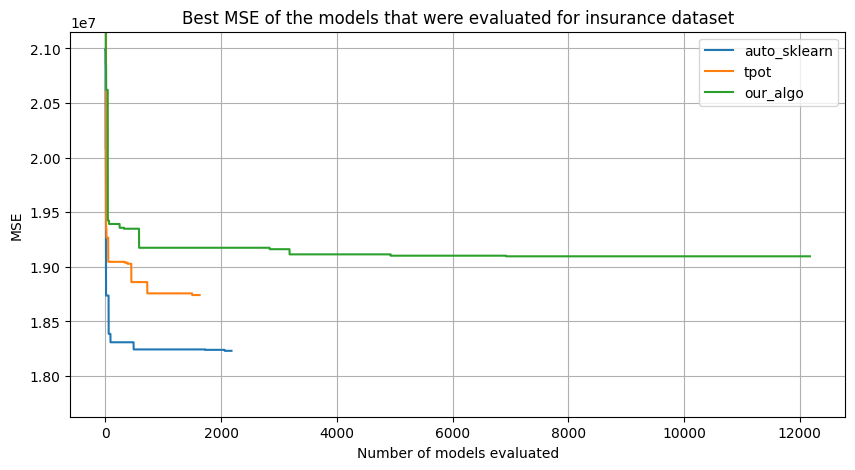

In [ ]:
dataset = "insurance"
mse_over_time_vectors = get_mse_from_result_files(dataset)
create_summary_graphs(mse_over_time_vectors, ["auto_sklearn", "tpot", "our_algo"], dataset, 0.5, 0.6)


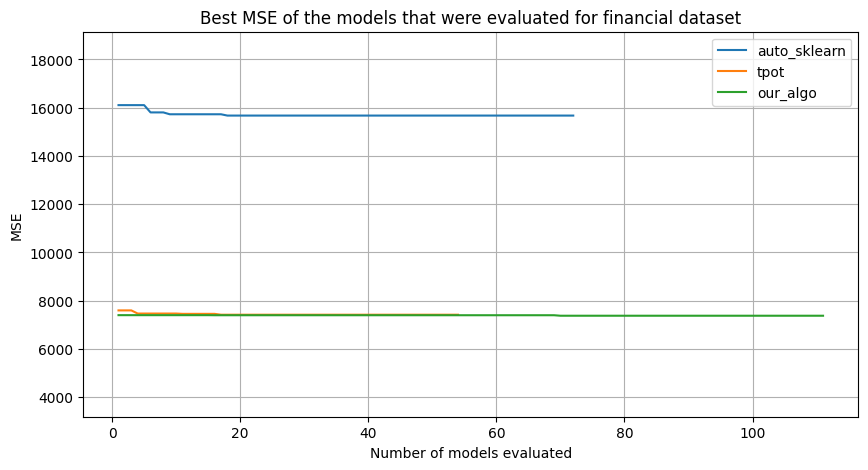

In [ ]:
dataset = "financial"
mse_over_time_vectors = get_mse_from_result_files(dataset)

create_summary_graphs(mse_over_time_vectors, ["auto_sklearn", "tpot", "our_algo"], dataset, 0.2, 1.2)

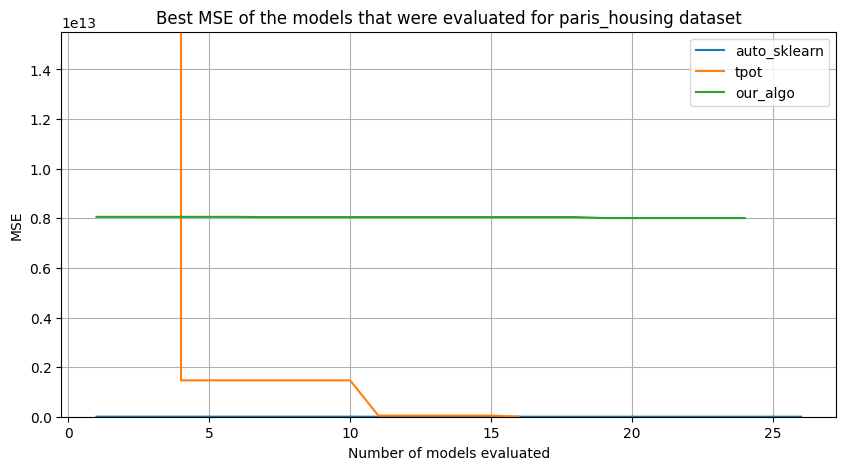

In [ ]:
dataset = "paris_housing"
mse_over_time_vectors = get_mse_from_result_files(dataset)
# , "our_algo"
create_summary_graphs(mse_over_time_vectors, ["auto_sklearn", "tpot", "our_algo"], dataset, 0, 7000)

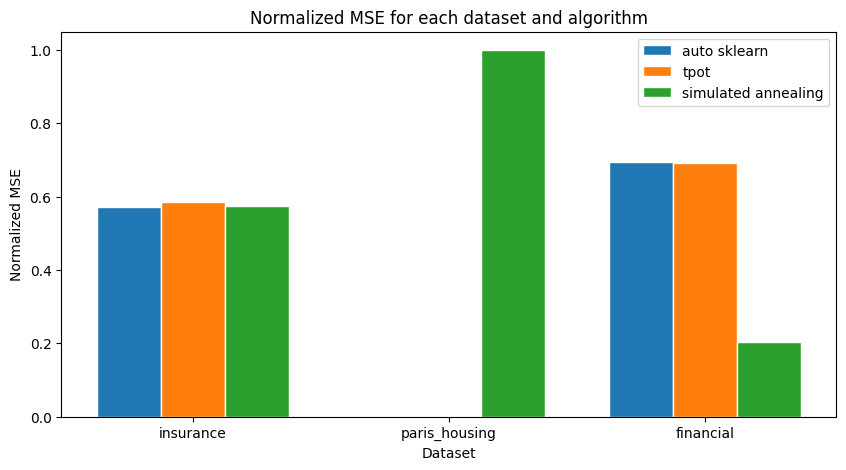

In [ ]:
barWidth = 0.25

insurance = normalize(np.array([25278442, 25930551, 25381165])[:,np.newaxis], axis=0).ravel()
paris_housing = normalize(np.array([16001654158, 16785709006, 8039413156428])[:,np.newaxis], axis=0).ravel()
financial = normalize(np.array([15970, 15903, 4653])[:,np.newaxis], axis=0).ravel()

auto_sklearn_bar = [insurance[0], paris_housing[0], financial[0]]
tpot_bar = [insurance[1], paris_housing[1], financial[1]]
simulated_annealing_bar = [insurance[2], paris_housing[2], financial[2]]

# Set position of bar on X axis
r1 = np.arange(len(auto_sklearn_bar))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, auto_sklearn_bar, width=barWidth, edgecolor='white', label='auto sklearn')
plt.bar(r2, tpot_bar, width=barWidth, edgecolor='white', label='tpot')
plt.bar(r3, simulated_annealing_bar, width=barWidth, edgecolor='white', label='simulated annealing')

plt.xticks([r + barWidth for r in range(len(auto_sklearn_bar))], ['insurance', 'paris_housing', 'financial'])

plt.xlabel('Dataset')
plt.title("Normalized MSE for each dataset and algorithm")
plt.ylabel("Normalized MSE")

# Create legend & Show graphic
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1aa6942e-536a-457c-8421-62372996b124' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>